We are going to reproject our raster projects to lat/lon for visualization.

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from orinoco import reproject_arr_to_match_profile, reproject_profile_to_new_crs
from pathlib import Path
import glob
from tqdm import tqdm
import geopandas as gpd
from rasterio.warp import calculate_default_transform

# Data Paths

In [5]:
tile_name = 'NR08'

tile_dir = Path(f'out/{tile_name}')
tile_dir.exists()

True

# Automate Reprojection

We get a reference rasterio profile from one of the rasters in the tile directory and then reproject all the rasters to that profile.

In [3]:
def get_reference_tif_profile(tile_name):
    with rasterio.open(tile_dir/f'distance_{tile_name}.tif') as ds:
        src_profile = ds.profile
    profile_4326 = reproject_profile_to_new_crs(src_profile, 
                                                'epsg:4326',
                                                 target_resolution= 0.0002
                                                )
    
    return profile_4326

def reproject_singe_band(tif_path, reference_profile, out_dir):
    # open raster with metadata
    with rasterio.open(tif_path) as ds:
        band = ds.read(1)
        profile = ds.profile
    
    # reproject data to reference profile
    band_r, _ = reproject_arr_to_match_profile(band, profile, reference_profile, resampling='nearest')
    # Reshape from (1 x m x n) to (m x n); we only have 1 channel images here
    band_r = band_r[0, ...]
    
    # Write reprojected array to disk
    p = reference_profile.copy()
    dtype = profile['dtype']
    p['dtype'] = dtype
    with rasterio.open(out_dir/tif_path.name, 'w', **p) as ds:
        ds.write(band_r.astype(dtype), 1)
    return out_dir/tif_path.name

def reproject_tile_data(tile_name):    
    # Get all the tifs from the tile directory
    tile_dir = Path(f'out/{tile_name}')
    tifs = list(tile_dir.glob('*.tif'))

    # Make a destination directory (if it doesn't already exist)
    out_dir = Path(str(tile_dir) + '_4326')
    out_dir.mkdir(exist_ok=True, parents=True)
    
    # Get reference profile
    reference_profile = get_reference_tif_profile(tile_name)
    
    
    # Reproject everything
    def reproj_partial(tif_path):
        return reproject_singe_band(tif_path, reference_profile, out_dir)
    
    out_tifs = list(map(reproj_partial, tqdm(tifs)))
    return out_tifs

In [4]:
reproject_tile_data(tile_name)

100%|██████████| 7/7 [00:30<00:00,  4.34s/it]


[PosixPath('out/NR08_4326/segments_NR08.tif'),
 PosixPath('out/NR08_4326/distance_NR08.tif'),
 PosixPath('out/NR08_4326/ocean_mask_NR08.tif'),
 PosixPath('out/NR08_4326/segments_rgb_NR08.tif'),
 PosixPath('out/NR08_4326/width_differences.tif'),
 PosixPath('out/NR08_4326/seg_test.tif'),
 PosixPath('out/NR08_4326/water_mask_NR08.tif')]

# Reproject the network to lat/lon

In [6]:
grwl_data = Path('grwl_data')
# Ignore hidden files
list(grwl_data.glob('[!.]*'))


[PosixPath('grwl_data/centerlines'), PosixPath('grwl_data/masks')]

This takes quite a bit of time - let's only do it once! And this is mainly to be able to plot the data in lat/lon. Again only aesthetic!

CPU times: user 16min 39s, sys: 1min 36s, total: 18min 16s
Wall time: 18min 16s


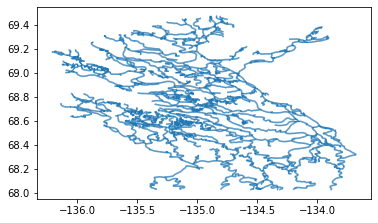

In [7]:
%%time

edges_grwl = gpd.read_file(grwl_data/'centerlines'/tile_name)
widths_df = gpd.read_file(tile_dir/'width_geometries.geojson').to_crs({'init':'epsg:4326'})
edges_orinoco = gpd.read_file(tile_dir/f'{tile_name}_edges.geojson').to_crs({'init':'epsg:4326'})
edges_orinoco.plot()

In [9]:
# From https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26#gistcomment-2353309
# To convert the data all into linestrings
def explode(gdf):
    """ 
    Explodes a geodataframe 
    
    Will explode muti-part geometries into single geometries. Original index is
    stored in column level_0 and zero-based count of geometries per multi-
    geometry is stored in level_1
    
    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries
        
    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with a new index 
                                 and two new columns: level_0 and level_1
        
    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out

In [11]:
out_dir = Path(str(tile_dir) + '_4326')
out_dir.mkdir(exist_ok=True, parents=True)

edges_grwl.to_file(out_dir/f'{tile_name}.geojson', driver='GeoJSON')

# We got an error for the width_df because there were multiline strings and line strings
explode(widths_df).to_file(out_dir/f'width_geometries.geojson', driver='GeoJSON')

edges_orinoco.to_file(out_dir/f'{tile_name}_edges.geojson', driver='GeoJSON')